# Week 05 — Clustering

This notebook surveys the three dominant clustering families:
- **Centroid-based**: K-means from scratch + sklearn
- **Density-based**: DBSCAN
- **Linkage-based**: agglomerative hierarchical clustering
- **Soft**: Gaussian Mixture Models

Evaluation: Silhouette, Davies-Bouldin, Adjusted Rand Index (ARI).

---
### 📚 Theory & References

- [📖 **Week 05 Theory** — Clustering](theory.md)
- [Week 04 — PCA for cluster visualisation](../week04_dimensionality_reduction/theory.md#4-principal-component-analysis-the-optimisation-view)
- [Week 00b — Distance metrics & norms](../../01_intro/week00b_math_and_data/theory.md#26-norms)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, load_iris
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                              adjusted_rand_score)
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

np.random.seed(42)
print('Libraries imported!')

Libraries imported!


In [ ]:
import os, pickle

CACHE_DIR = 'cache_week05_clustering'
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f'{key}.pkl'), 'wb') as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f'{key}.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print('Cache utilities ready:', CACHE_DIR)

Cache utilities ready: cache_week03_clustering


## 1. K-Means from Scratch (Lloyd's Algorithm)

K-means minimises the **within-cluster sum of squares** (inertia):  
$\sum_{k=1}^{K} \sum_{x \in C_k} \|x - \mu_k\|^2$

Lloyd's algorithm alternates between:
1. **Assign** each point to the nearest centroid.
2. **Update** each centroid to the mean of its assigned points.

Inertia: 362.47
ARI vs true labels: 1.0000


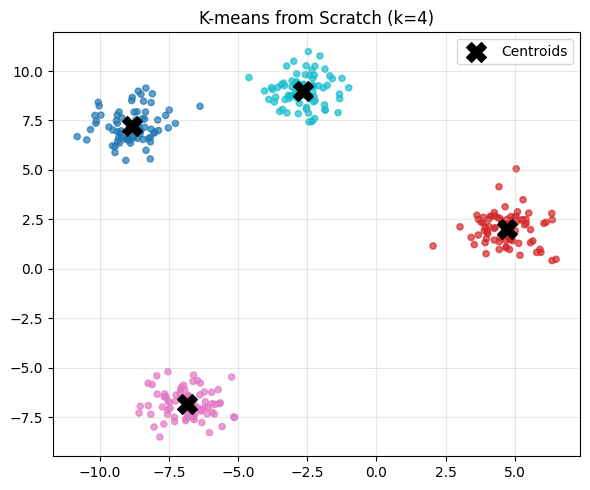

In [3]:
def kmeans_from_scratch(X, k, max_iter=300, tol=1e-4, random_state=42):
    """Lloyd's k-means.

    Returns
    -------
    labels    : ndarray (n,)  — cluster assignments
    centroids : ndarray (k, p) — final centroid positions
    inertia   : float         — final WCSS
    """
    rng = np.random.default_rng(random_state)
    # k-means++ initialisation: spread initial centroids
    idx0 = rng.integers(len(X))
    centroids = [X[idx0]]
    for _ in range(k - 1):
        dists = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids], axis=0)
        probs = dists / dists.sum()
        centroids.append(X[rng.choice(len(X), p=probs)])
    centroids = np.array(centroids)

    for _ in range(max_iter):
        # Assign
        dists = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)  # (n, k)
        labels = np.argmin(dists, axis=1)
        # Update
        new_centroids = np.vstack([X[labels == j].mean(axis=0) if (labels == j).any()
                                   else centroids[j] for j in range(k)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    inertia = sum(np.sum((X[labels == j] - centroids[j]) ** 2) for j in range(k))
    return labels, centroids, inertia


# Test on make_blobs
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)
labels, centroids, inertia = kmeans_from_scratch(X_blobs, k=4)

print(f'Inertia: {inertia:.2f}')
print(f'ARI vs true labels: {adjusted_rand_score(y_blobs, labels):.4f}')

plt.figure(figsize=(6, 5))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='black', zorder=5, label='Centroids')
plt.title('K-means from Scratch (k=4)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

## 2. Elbow Method & Silhouette Score

[cache] computing 'elbow_silhouette_blobs'...


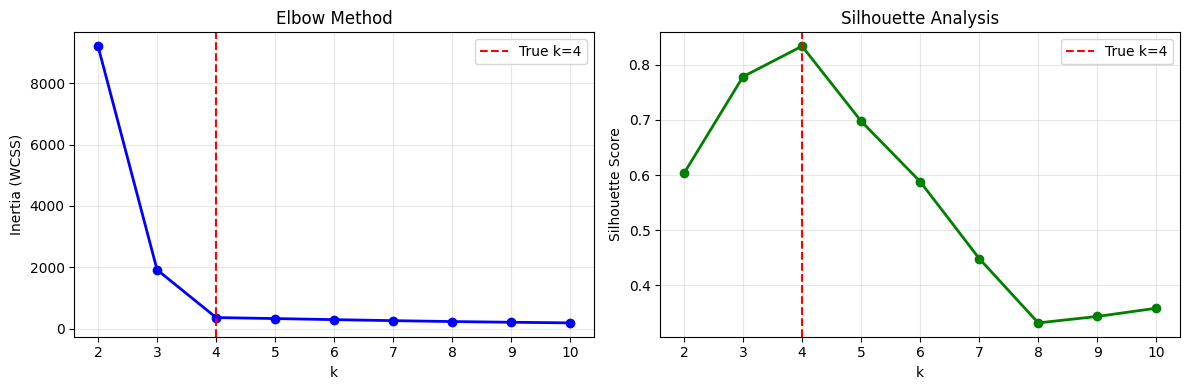

In [4]:
def _run_elbow_silhouette():
    ks = range(2, 11)
    inertias, sil_scores = [], []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        lbl = km.fit_predict(X_blobs)
        inertias.append(km.inertia_)
        sil_scores.append(silhouette_score(X_blobs, lbl))
    return list(ks), inertias, sil_scores

ks, inertias, sil_scores = cached('elbow_silhouette_blobs', _run_elbow_silhouette)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(ks, inertias, 'bo-', linewidth=2)
axes[0].axvline(4, color='red', linestyle='--', label='True k=4')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Elbow Method'); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].plot(ks, sil_scores, 'go-', linewidth=2)
axes[1].axvline(4, color='red', linestyle='--', label='True k=4')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis'); axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 3. DBSCAN vs K-Means on Non-Convex Clusters

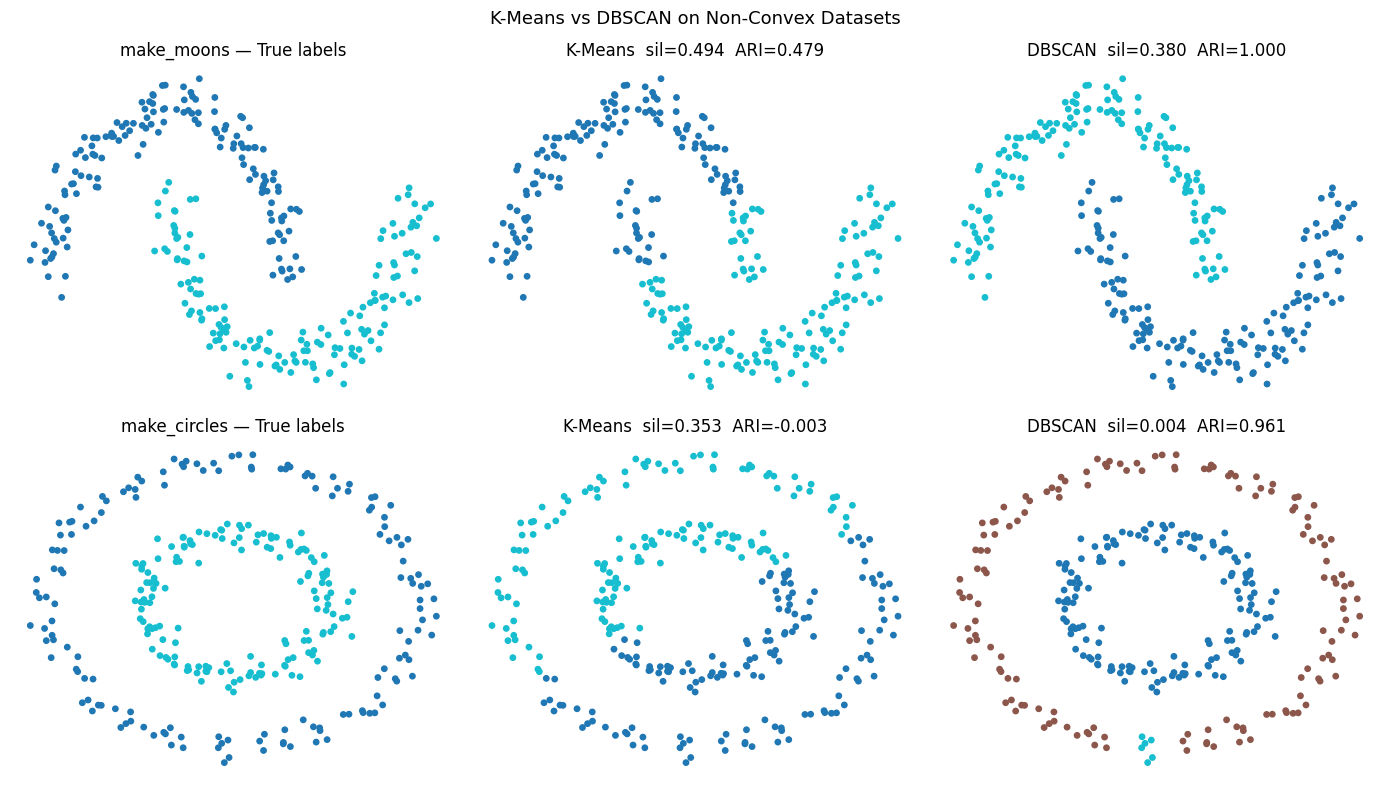

In [5]:
datasets = {
    'make_moons':   make_moons(n_samples=300, noise=0.08, random_state=42),
    'make_circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42),
}

fig, axes = plt.subplots(len(datasets), 3, figsize=(14, 8))

for row, (name, (X_d, y_d)) in enumerate(datasets.items()):
    X_s = StandardScaler().fit_transform(X_d)
    # True labels
    axes[row, 0].scatter(X_s[:, 0], X_s[:, 1], c=y_d, cmap='tab10', s=15)
    axes[row, 0].set_title(f'{name} — True labels')
    # K-means
    km_lbl = KMeans(n_clusters=2, n_init=10, random_state=42).fit_predict(X_s)
    sil_km = silhouette_score(X_s, km_lbl)
    axes[row, 1].scatter(X_s[:, 0], X_s[:, 1], c=km_lbl, cmap='tab10', s=15)
    axes[row, 1].set_title(f'K-Means  sil={sil_km:.3f}  ARI={adjusted_rand_score(y_d, km_lbl):.3f}')
    # DBSCAN
    db_lbl = DBSCAN(eps=0.3, min_samples=5).fit_predict(X_s)
    mask_core = db_lbl != -1
    if mask_core.sum() > 1:
        sil_db = silhouette_score(X_s[mask_core], db_lbl[mask_core])
        ari_db = adjusted_rand_score(y_d, db_lbl)
    else:
        sil_db = ari_db = float('nan')
    axes[row, 2].scatter(X_s[:, 0], X_s[:, 1], c=db_lbl, cmap='tab10', s=15)
    axes[row, 2].set_title(f'DBSCAN  sil={sil_db:.3f}  ARI={ari_db:.3f}')
    for ax in axes[row]:
        ax.axis('off')

plt.suptitle('K-Means vs DBSCAN on Non-Convex Datasets', fontsize=13)
plt.tight_layout(); plt.show()

## 4. Hierarchical Clustering & Dendrogram

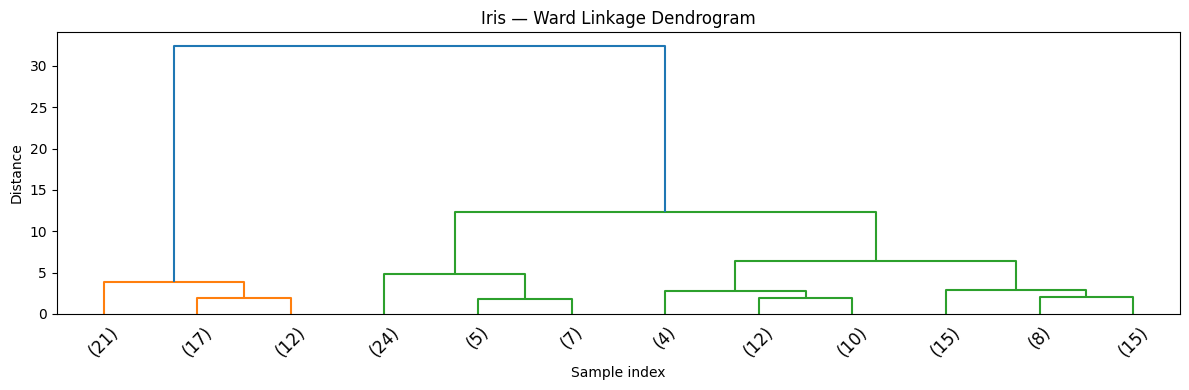

Hierarchical (Ward, k=3)  ARI = 0.7312
                     Silhouette = 0.5543


In [6]:
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

def plot_dendrogram(X, method='ward', truncate_p=12, title='Dendrogram'):
    Z = linkage(X, method=method)
    fig, ax = plt.subplots(figsize=(12, 4))
    dendrogram(Z, ax=ax, truncate_mode='lastp', p=truncate_p,
               show_leaf_counts=True, leaf_rotation=45)
    ax.set_title(title); ax.set_xlabel('Sample index'); ax.set_ylabel('Distance')
    plt.tight_layout(); plt.show()
    return Z

Z_iris = plot_dendrogram(X_iris, title='Iris — Ward Linkage Dendrogram')

# Cut into 3 clusters
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
hier_labels = agg.fit_predict(X_iris)
print(f'Hierarchical (Ward, k=3)  ARI = {adjusted_rand_score(y_iris, hier_labels):.4f}')
print(f'                     Silhouette = {silhouette_score(X_iris, hier_labels):.4f}')

## 5. Gaussian Mixture Model (Soft Clustering)

In [7]:
def _fit_gmm_iris():
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
    gmm.fit(X_iris)
    return gmm

gmm_iris = cached('gmm_iris_k3', _fit_gmm_iris)
gmm_labels = gmm_iris.predict(X_iris)
print(f'GMM (k=3)     ARI = {adjusted_rand_score(y_iris, gmm_labels):.4f}')
print(f'              Silhouette = {silhouette_score(X_iris, gmm_labels):.4f}')

# Comparison table
km_sklearn = KMeans(n_clusters=3, n_init=10, random_state=42).fit_predict(X_iris)
print('\n--- Iris cluster evaluation summary ---')
for name, lbls in [('K-Means', km_sklearn), ('Hierarchical', hier_labels), ('GMM', gmm_labels)]:
    print(f"  {name:<15} ARI={adjusted_rand_score(y_iris, lbls):.4f}  "
          f"Sil={silhouette_score(X_iris, lbls):.4f}  "
          f"DB={davies_bouldin_score(X_iris, lbls):.4f}")

[cache] computing 'gmm_iris_k3'...
GMM (k=3)     ARI = 0.9039
              Silhouette = 0.5012

--- Iris cluster evaluation summary ---
  K-Means         ARI=0.7302  Sil=0.5528  DB=0.6620
  Hierarchical    ARI=0.7312  Sil=0.5543  DB=0.6563
  GMM             ARI=0.9039  Sil=0.5012  DB=0.7483


## Exercises

1. **K-means recovery** — generate `make_blobs` with 4 known centroids at (-3,0), (3,0), (0,3), (0,-3). Run `kmeans_from_scratch(X, k=4)` and check that recovered centroids are within 0.5 of truth.
2. **Elbow + Silhouette** — run k from 2 to 10 on `make_blobs`; plot both curves; identify the best k.
3. **DBSCAN parameter sweep** — for `make_moons`, vary `eps` in [0.1, 0.2, …, 0.6]; plot noise fraction vs ARI.
4. **Hierarchical linkage comparison** — repeat the iris dendrogram with `single`, `complete`, and `average` linkage; compare ARI scores.
5. **GMM BIC selection** — fit GMM with k from 1 to 8 on iris; plot BIC vs k; pick optimal k.

In [8]:
# EXERCISE 1 — K-means centroid recovery
# Goal: generate blobs at known centres; verify kmeans_from_scratch recovers them within 0.5.

In [9]:
# EXERCISE 2 — Elbow + Silhouette (already shown above — generalise to other datasets)
# Goal: repeat the elbow/silhouette analysis for make_moons.
# Observe: both metrics may suggest k=2, but DBSCAN performs better.

In [10]:
# EXERCISE 3 — DBSCAN eps sweep
# Goal: for make_moons, iterate eps over np.arange(0.1, 0.7, 0.1).
# For each eps, report: n_clusters found, noise fraction, ARI.
# Plot ARI vs eps.

In [11]:
# EXERCISE 4 — Linkage comparison
# Goal: fit AgglomerativeClustering(linkage=lnk) for lnk in ['ward','single','complete','average'].
# Report ARI and silhouette for each on iris.

In [12]:
# EXERCISE 5 — GMM BIC selection
# Goal: fit GaussianMixture(n_components=k) for k in range(1, 9) on iris.
# Plot BIC vs k; mark the minimum.
# Expected: BIC picks k=3 (matching the true number of species).